In [147]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
pd.set_option("display.max_rows", 100)

In [148]:
# read csv files orders and positions
position = pd.read_csv("positions.csv")
order = pd.read_csv("orders.csv")

position["time"] = pd.to_datetime(position["time"])
order["time"] = pd.to_datetime(order["time"])

position["date"] = pd.to_datetime(position["time"].dt.date)
order["date"] = pd.to_datetime(order["time"].dt.date)
dates = pd.Index(pd.to_datetime(get_trading_dates("20230103", "20230428", market='cn')),name="date")

In [149]:
order = order[order["filled"]!=0]

In [150]:
temp = pd.DataFrame(order[["security","security_name","date","amount","action","filled","price"]])
temp["direction"] = temp["action"].map(lambda x: 1 if x == "open" else -1)
temp["direction"] = temp["direction"] * temp["filled"]

In [151]:
temp1 = temp.pivot_table(index = "date", columns = "security", values = "direction",aggfunc = "sum")

In [152]:
temp1 = temp1.reindex(dates)
temp1 = temp1.fillna(0)
temp1 = temp1.cumsum()

In [153]:
open_filter = (temp1>0) & (temp1.shift(1).fillna(0.) == 0)
holding_filter = (temp1>0) & (temp1.shift(1).fillna(0.) > 0)
close_filter = (temp1==0) & (temp1.shift(1).fillna(0.) > 0 )

In [154]:
open = temp1.where(open_filter,other = np.nan)
open = open.stack().to_frame()
open = open.reset_index()

In [155]:
open["rank"] = open.groupby(["security"]).cumcount()+1

In [156]:
temp2 = open.pivot_table(index = "date", columns = "security", values = "rank")
temp2 = temp2.reindex(dates)

In [157]:
temp2 = temp2.where(open_filter|holding_filter|close_filter,other = -9999)
temp2 = temp2.ffill(axis=0)

In [158]:
temp2 = temp2.replace({-9999:np.nan})

In [159]:
temp2 = temp2.stack().to_frame("rank").reset_index()

In [160]:
temp2["orderid"] = temp2["security"]+temp2["rank"].astype(int).astype(str).str.zfill(3)

In [161]:
temp2["date"] = pd.to_datetime(temp2["date"])

In [162]:
result = temp.copy()
result = result.merge(temp2,on=["date","security"],how = "left")

In [163]:
# result[result["security"]=="002719.XSHE"]

In [164]:
avg_price = result.groupby(["orderid","date"]).apply(lambda x: sum(x["price"]*x["filled"])/sum(x["amount"])).to_frame("avg_price")
avg_price = avg_price.reset_index()

In [165]:
result = result.merge(avg_price,on = ["date","orderid"])

In [166]:
times = order.pivot_table(index = ["security","date","filled"], columns = "action",values = "time",aggfunc = "min")
times["open"] = times["open"].ffill(axis='rows')
times = times.rename(columns = {"close":"close_time", "open":"open_time"})
times = times[["open_time","close_time"]].reset_index()

In [167]:
result = result.merge(times, on = ["security","date","filled"])

In [168]:
# result[result["security"]=="002719.XSHE"]

In [169]:
avg_price_new = result.pivot_table(index = ["orderid"], columns = "action",values = "avg_price")
avg_price_new = avg_price_new.rename(columns = {"close" : "avg_sell_price","open" : "avg_buy_price"})
avg_price_new = avg_price_new[["avg_buy_price","avg_sell_price"]]

In [170]:
trade_qty = result.pivot_table(index = ["orderid"], columns = "action",values = "amount",aggfunc = "sum")
trade_qty["trade_qty"] = trade_qty["open"]
trade_qty = trade_qty.drop(["close","open"],axis=1).reset_index()

In [171]:
new_times = result[result["action"]=="close"][["orderid","security","open_time","close_time"]]
# new_times[new_times["security"]=="002719.XSHE"]

In [172]:
new_results = new_times.merge(avg_price_new, on = ["orderid"])

In [173]:
new_results = new_results.merge(trade_qty, on = ["orderid"])

In [174]:
new_results["price_change"] = (new_results["avg_sell_price"]/new_results["avg_buy_price"])-1
new_results["profit/deficit"] = (new_results["avg_sell_price"]*new_results["trade_qty"])-(new_results["avg_buy_price"]*new_results["trade_qty"])

In [175]:
# win_value = new_results[new_results["profit/deficit"] > 0].shape[0] / new_results.shape[0]
# win_rate = f"{(win_value)*100}%"
# win_rate

In [176]:
ratio = new_results["price_change"][new_results["price_change"] > 0].mean()/new_results["price_change"][new_results["price_change"] < 0].mean()
ratio

-1.3310052517246922

In [177]:
bins=list(np.arange(-0.2,0.4,0.01).round(2))

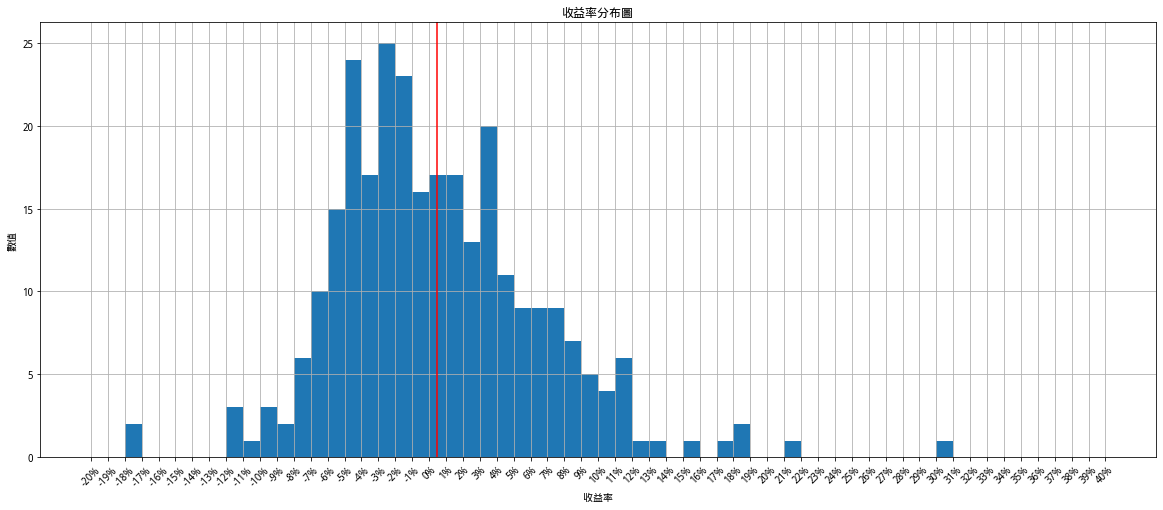

In [178]:
ax = new_results["price_change"].plot(kind='hist', bins=bins, title='收益率分布圖', grid=True, figsize=(20,8))
plt.xticks(bins,rotation = 45)
plt.xlabel('收益率')
plt.ylabel("數值")
plt.axvline(x = new_results["price_change"].mean(), color = 'r')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [179]:
new_results["date"] = pd.to_datetime(new_results["open_time"].dt.date)

In [180]:
codes = [*set(list(new_results["security"]))]
prices = get_price(codes, "20230103", "20230428")[["high","limit_up","open","close"]]
prices = prices.reset_index()
prices[prices["order_book_id"]=="301075.XSHE"]
prices["date"] = pd.to_datetime(prices["date"])
prices = prices.rename(columns = {"order_book_id":"security", "open": "open_price", "close": "close_price"})

In [181]:
new_results = new_results.merge(prices, on = ["security","date"])

In [182]:
new_results["profit_rate_x"] = (new_results["close_price"] / new_results["avg_buy_price"]) -1
new_results["profit_rate_y"] = (new_results["avg_sell_price"] / new_results["close_price"]) -1

In [183]:
# new_results

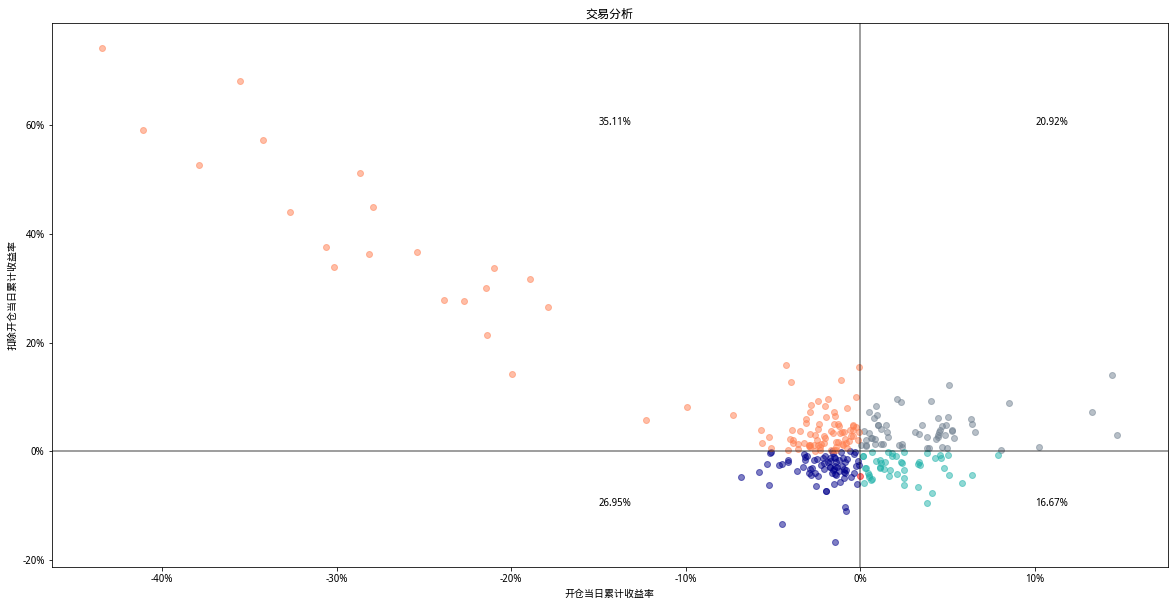

In [184]:
x = new_results["profit_rate_x"]
y = new_results["profit_rate_y"]
slategrey = (x > 0) & (y > 0)
darkblue = (x < 0) & (y < 0)
lightseagreen = (x > 0) & (y < 0)
coral = (x < 0) & (y > 0)
red = (x==0) | (y==0)

label1 = f"{(len(x[slategrey])/len(x)*100):.2f}%"
label2 = f"{(len(x[darkblue])/len(x)*100):.2f}%"
label3 = f"{(len(x[lightseagreen])/len(x)*100):.2f}%"
label4 = f"{(len(x[coral])/len(x)*100):.2f}%"

plt.figure(figsize = (20,10))
plt.scatter(x[slategrey], y[slategrey], color = 'slategrey', alpha = 0.5)
plt.scatter(x[darkblue], y[darkblue], color = 'darkblue', alpha = 0.5)
plt.scatter(x[lightseagreen], y[lightseagreen], color = 'lightseagreen', alpha = 0.5)
plt.scatter(x[coral], y[coral], color = 'coral', alpha = 0.5)
plt.scatter(x[red], y[red], color = 'red', alpha = 0.5)


plt.axvline(x = 0, color = 'black', alpha = 0.5)
plt.axhline(y = 0, color = 'black', alpha = 0.5)


plt.annotate(label1,(0.1,0.6))
plt.annotate(label2,(-0.15,-0.1))
plt.annotate(label3,(0.1,-0.1))
plt.annotate(label4,(-0.15,0.6))


plt.title('交易分析')
plt.xlabel('开仓当日累计收益率')
plt.ylabel("扣除开仓当日累计收益率")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [185]:
new_results["hit_limit"] = new_results["high"] == new_results["limit_up"]
new_results["profit"] = new_results["profit/deficit"] > 0

In [186]:
limits = pd.DataFrame(new_results[new_results["price_change"].between(-0.1,0.1)])

In [187]:
groups=list(np.arange(-0.1,0.11,0.01).round(2))
limits["區間"] = pd.cut(limits["price_change"], bins = groups).to_frame()

In [188]:
temp = limits[["區間","orderid","hit_limit","profit_rate_y"]]

grp = temp.groupby("區間")
df1 = grp.size().to_frame('數量')
df2 = (grp.apply(lambda i: i[i['profit_rate_y'] > 0].shape[0]) / grp['profit_rate_y'].count()).to_frame('勝率')
df3 = (grp.apply(lambda i: i[i['profit_rate_y'] < 0].shape[0]) / grp['profit_rate_y'].count()).to_frame('賠率')
df4 = grp.apply(lambda i: i.loc[i['profit_rate_y'] > 0, 'profit_rate_y'].mean() / i.loc[i['profit_rate_y'] < 0, 'profit_rate_y'].mean()).abs().to_frame('盈虧比')

temp2 = limits[["區間","orderid","hit_limit","profit_rate_y"]]
temp2 = temp2[temp2["hit_limit"]==False]

grp2 = temp2.groupby("區間")
df5 = grp2.size().to_frame('非漲停股數量')
df6 = (grp2.apply(lambda i: i[i['profit_rate_y'] > 0].shape[0]) / grp2['profit_rate_y'].count()).to_frame('去處漲停股後的勝率')
df7 = (grp2.apply(lambda i: i[i['profit_rate_y'] < 0].shape[0]) / grp2['profit_rate_y'].count()).to_frame('去處漲停股後的賠率')
df8 = grp2.apply(lambda i: i.loc[i['profit_rate_y'] > 0, 'profit_rate_y'].mean() / i.loc[i['profit_rate_y'] < 0, 'profit_rate_y'].mean()).abs().to_frame('去處漲停股後的盈虧比')


final = df1.join([df2,df3,df4,df5,df6,df7,df8])

In [189]:
final["凱利公式"] = (final["勝率"]*final["盈虧比"]-final["賠率"])/final["盈虧比"]
final["去處漲停股後的凱利公式"] = (final["去處漲停股後的勝率"]*final["去處漲停股後的盈虧比"]-final["去處漲停股後的賠率"])/final["去處漲停股後的盈虧比"]
final["漲停股數量"] = final["數量"] - final["非漲停股數量"]

In [190]:
final = final[["數量","勝率","盈虧比","凱利公式","漲停股數量","去處漲停股後的勝率","去處漲停股後的盈虧比","去處漲停股後的凱利公式"]]

In [191]:
final

,數量,勝率,盈虧比,凱利公式,漲停股數量,去處漲停股後的勝率,去處漲停股後的盈虧比,去處漲停股後的凱利公式
區間,,,,,,,,
"(-0.1, -0.09]",3,0.000000,NaN,NaN,0,0.000000,NaN,NaN
"(-0.09, -0.08]",2,0.500000,2.251847,0.277960,0,0.500000,2.251847,0.277960
"(-0.08, -0.07]",6,0.166667,1.546704,-0.372113,0,0.166667,1.546704,-0.372113
"(-0.07, -0.06]",10,0.200000,9.532984,0.116081,0,0.200000,9.532984,0.116081
"(-0.06, -0.05]",15,0.066667,16.301963,0.009414,1,0.071429,16.249120,0.014283
"(-0.05, -0.04]",24,0.166667,4.673861,-0.011630,0,0.166667,4.673861,-0.011630
"(-0.04, -0.03]",17,0.176471,4.930715,0.009450,4,0.230769,6.919187,0.119596
"(-0.03, -0.02]",25,0.440000,3.080639,0.258220,3,0.454545,3.941372,0.316153
"(-0.02, -0.01]",23,0.608696,4.236080,0.516321,2,0.571429,3.741407,0.456880


In [192]:
final.index = final.index.astype(str)

In [193]:
plot = final

In [194]:
plot

,數量,勝率,盈虧比,凱利公式,漲停股數量,去處漲停股後的勝率,去處漲停股後的盈虧比,去處漲停股後的凱利公式
區間,,,,,,,,
"(-0.1, -0.09]",3,0.000000,NaN,NaN,0,0.000000,NaN,NaN
"(-0.09, -0.08]",2,0.500000,2.251847,0.277960,0,0.500000,2.251847,0.277960
"(-0.08, -0.07]",6,0.166667,1.546704,-0.372113,0,0.166667,1.546704,-0.372113
"(-0.07, -0.06]",10,0.200000,9.532984,0.116081,0,0.200000,9.532984,0.116081
"(-0.06, -0.05]",15,0.066667,16.301963,0.009414,1,0.071429,16.249120,0.014283
"(-0.05, -0.04]",24,0.166667,4.673861,-0.011630,0,0.166667,4.673861,-0.011630
"(-0.04, -0.03]",17,0.176471,4.930715,0.009450,4,0.230769,6.919187,0.119596
"(-0.03, -0.02]",25,0.440000,3.080639,0.258220,3,0.454545,3.941372,0.316153
"(-0.02, -0.01]",23,0.608696,4.236080,0.516321,2,0.571429,3.741407,0.456880


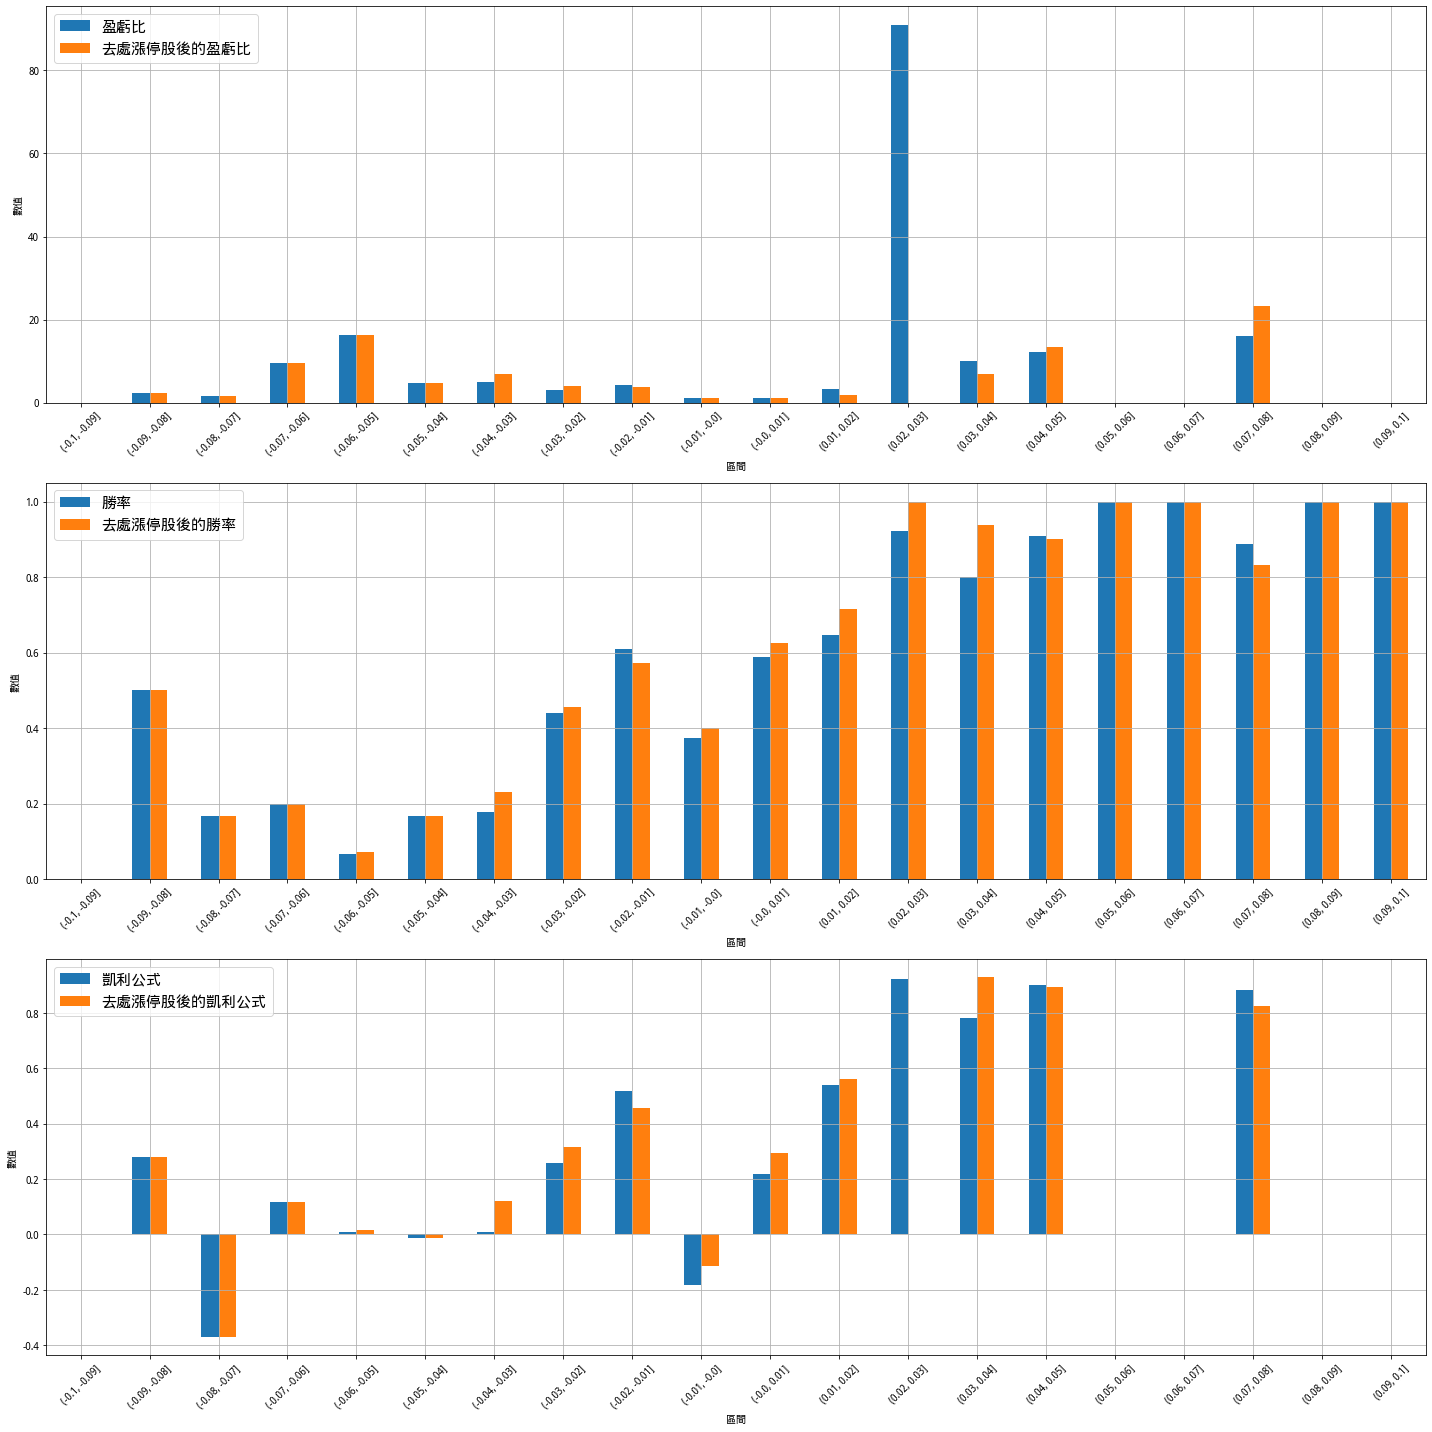

In [195]:
fig = plt.figure(figsize = (20,20))


ax=plt.subplot(311)
plot[["盈虧比","去處漲停股後的盈虧比"]].plot.bar(ax=ax)
ax.set_xticklabels(plot.index,rotation = 45)
ax.set_ylabel("數值")
ax.legend(loc = "upper left", prop={'size': 15})
ax.grid()

ax=plt.subplot(312)
plot[["勝率","去處漲停股後的勝率"]].plot.bar(ax=ax)
ax.set_xticklabels(plot.index,rotation = 45)
ax.set_ylabel("數值")
ax.legend(loc = "upper left", prop={'size': 15})
ax.grid()

ax=plt.subplot(313)
plot[["凱利公式","去處漲停股後的凱利公式"]].plot.bar(ax=ax)
ax.set_xticklabels(plot.index,rotation = 45)
ax.set_ylabel("數值")
ax.legend(loc = "upper left", prop={'size': 15})
ax.grid()

fig.tight_layout()
